In [5]:
from PIL import Image, ImageDraw #Подключим необходимые библиотеки. 
import numpy as np
import datetime

def topix(path,iswhit=200):
    #mode = 1 #int(input('mode:')) #Считываем номер преобразования. Нафиг вообще надо?
    image = Image.open(path) #Открываем изображение. 
    #draw = ImageDraw.Draw(image) #Создаем инструмент для рисования. 
    #width = image.size[0] #Определяем ширину. 
    #height = image.size[1] #Определяем высоту. 
    #pix_temp = image.load() #Выгружаем значения пикселей.
    pix = np.array(image)
    pix=np.array(pix.mean(axis=2)) # усредняем пиксели
    pix=np.array(pix>=iswhit)*1 # умножаем на 1, чтобы из булевых сделать 1/0
    
    #pix=np.array([[int(j) for j in i] for i in pix]) 
    #pix=np.array([list(map(lambda x: int(x),i)) for i in pix])
    # переводим булевые в 1/0. в qq2 не прокатывает - функция int к массиву напрямую не применяется
    # хотя вроде работает и на true/false, и довольно быстро

    #pix=np.array([iswhite(i) for i in pix]) # сразу переводим в 1/0
    #pix=np.array([sum(i) for i in pix])
    #for i in pix:
    #    print(i.mean())
    return pix

def iswhite(pixel):
    if pixel.ndim==1:
        return np.array([int(sum(pixel)/len(pixel)>=220)])
    elif pixel.ndim==2:
        return np.array([int(sum(p)/len(p)>=220) for p in pixel])
    elif pixel.ndim==3:
        return np.array([int(sum(p)/len(p)>=220) for col in pixel for p in col])

def evklid(a,b):
    #return np.sqrt(sum( (x1 - x2)**2 for x1, x2 in zip(a, b)))
    return np.sqrt(sum((a-b)**2))

#
# поиск буквы по метрике
#
def whatis(dic,letter,accuracy=10):
    #threshold=10 # до какого порога считаем буквы одинаковыми. 7 - стали путать с/о
    if len(dic)==0: return ['',0]
    qqq=np.array([[evklid(letter,np.array(i[0]))] for i in dic])
    #min_evklid=qqq.min()
    
    if qqq.min()<=accuracy:
        #print(qqq)
        #print('----------')
        #print(min_evklid) 
        #print(dic[sum(np.where(qqq == min_evklid)[0])][1])
        #return dic[np.unravel_index(min_evklid, qqq.shape)[0]]
        
        #return dic[min(np.where(qqq == min_evklid)[0])][1]
        return [dic[qqq.argmin()][1],qqq.min()]
    else:
        return ['',0]
    
def whatis_vect(dic, dicl,letter,accuracy=10):
    #threshold=10 # до какого порога считаем буквы одинаковыми. 7 - стали путать с/о
    if len(dic)==2: return ['',0]
    qqq=np.sqrt(((dic-letter)**2).sum(axis=1))
    min_evklid=qqq.min()

    if min_evklid<=accuracy:
        #print(qqq)
        #print('----------')
        #print(min_evklid) 
        #print(dic[sum(np.where(qqq == min_evklid)[0])][1])
        #return dic[np.unravel_index(min_evklid, qqq.shape)[0]]
        
        #return dic[min(np.where(qqq == min_evklid)[0])][1]
        return [dicl[qqq.argmin()][0],min_evklid,dicl[qqq.argmin()][1]]
    else:
        return ['',0,'']
    
#
# считывание словаря из файла
#
def dic_refresh():
    dic=[] # без NP, т.к. разных типов
    f = open('dict_oliver.txt', 'r')
    for line in f:
        if line.startswith('X'):
            #print(line.strip().split(' '))
            s=line.strip().split(' ')
            dic.append([[float(x) for x in s[1:-1]],s[-1]])
    f.close
    return dic

def dic_refresh_vect(dic_name):
    dic=np.array([0,0,0,0,0,0,0,0,0])
    dicl=['xxx','ind']
    f = open(dic_name, 'r')
    for line in f:
        if line.startswith('X'):
            #print(line.strip().split(' '))
            s=line.strip().split(' ')
            dic=np.vstack([dic,[float(x) for x in s[1:-1]]])
            #dicl=np.vstack([dicl,s[-1]])
            dicl=np.vstack([dicl,[s[-1],s[0]]])
    f.close
    
    
    return dic,dicl

#
# запись нового символа в словарь
#
def add_to_dict(pix,i_first,i,j_first,j,lendic,dic_name,realtimerecognize):
    if realtimerecognize==1:
        vvod=input()
    else:
        vvod='{'+'X'+str(lendic+1)+'}'
    if not(vvod=='' or vvod=='XXX'):
        f = open(dic_name, 'a') # дозапись
        f.write('X'+str(lendic+1)+' ') # чтобы проще искать
        f.write(' '.join([str(x) for x in quat(pix[i_first:i,j_first:j])])) # изначально выдаётся список чисел. А join не работает с числами
        f.write(' ' + str(vvod)) #f.write(' ХXXXXX')
        f.write('\n')
        for ii in range(i_first,i):
            for jj in range(j_first,j):
                f.write(str(pix[ii, jj]))
            f.write('\n')
        f.write('\n')
        f.close()
    
    


def quat(pix):
    # вычисляем всегда, т.к. всё равно пригодится в конце.
    row_mean=(pix.shape[0] // 2) # единицу не прибавляем, т.к. отсчёт с нуля
    col_mean=(pix.shape[1] // 2)
    s0=pix.shape[0]
    s1=pix.shape[1]
    
    if pix.shape[0] % 2 == 1: #если нечётное колво строк
        pix_t=np.array(pix)
        #pix=np.append(pix,[pix[row_mean,:]],axis=0)
        pix=np.append(pix_t[0:row_mean+1,:],[pix_t[row_mean,:]],axis=0)
        pix=np.append(pix,pix_t[(row_mean+1):,:],axis=0)
        row_mean=row_mean+1 
    if pix.shape[1] % 2 == 1: #если нечётное колво столбцов
        pix_t=np.array(pix)
        #pix=np.append(pix,pix[:,col_mean,np.newaxis],axis=1)
        pix=np.append(pix_t[:,0:col_mean+1],pix_t[:,col_mean,np.newaxis],axis=1)
        pix=np.append(pix,pix_t[:,(col_mean+1):],axis=1)
        col_mean=col_mean+1
    
    sum_gorizont1=0
    for i in range(col_mean):
        sum_gorizont1+=sum((i+1)*pix[:,i]) # показатель центровки. Смотрим левую половину. Чем ближе к центру, тем больше стоимость
    
    sum_gorizont2=0
    for i in range(col_mean, pix.shape[1]):
        sum_gorizont2+=sum((i+1-col_mean)*pix[:,i])

    sum_gorizont_max=sum([x for x in range(1,col_mean+1)])*pix.shape[0] # максимально возможная сумма

    sum_vertical1=0
    for i in range(row_mean):
        sum_vertical1+=sum((i+1)*pix[i,:]) # показатель центровки. Смотрим верхнюю половину. Чем ближе к центру, тем больше стоимость
                
    sum_vertical2=0
    for i in range(row_mean, pix.shape[0]):
        sum_vertical2+=sum((i+1-row_mean)*pix[i,:])
    
    sum_vertical_max=sum([x for x in range(1,row_mean+1)])*pix.shape[1] # максимально возможная сумма
    
    # перебираем по часовой стрелке с верхнего левого
    # и отношение высоты к длине ненормировано. Нехорошо
    return np.array([round(100*np.mean(pix[:row_mean,:col_mean]),4), \
            round(100*np.mean(pix[:row_mean,col_mean:]),4), \
            round(100*np.mean(pix[row_mean:,col_mean:]),4), \
            round(100*np.mean(pix[row_mean:,:col_mean]),4), \
            round(100*(sum_gorizont1/sum_gorizont_max if sum_gorizont_max>0 else 0),4), \
            round(100*(sum_gorizont2/sum_gorizont_max if sum_gorizont_max>0 else 0),4), \
            round(100*(sum_vertical1/sum_vertical_max if sum_vertical_max>0 else 0),4),\
            round(100*(sum_vertical2/sum_vertical_max if sum_vertical_max>0 else 0),4),\
            round(100*(1.0*pix.shape[0]/pix.shape[1] if pix.shape[1] else 0),4) if s0<4*s1 else round(100*(1.0*s0/s1 if s1 else 0),4)])
# - последнее - костыль из-за похожести | и '. У палки было 3 на 20, но ширина добавлялась до чётной, получалось 4 на 20, что совпадало с идеальной кавычкой

def check_or(dlina,pix,words_count,stroka,strok):
    if dlina[0]<=18: return 1
    if dlina[0]>80: return 1 #было 45
    if dlina[1]/dlina[0]<=20: return 1
    if sum(sum(pix[strok:(strok+dlina[0]),(pix.shape[1]//2-35):(pix.shape[1]//2+35)]))<10: return 1
    if len(stroka)>words_count: return 1 # если высота строки меньше 20 или ширина строки меньше 20 (совпадение чисел - случайно)- скорее всего, помехи
    return 0 # если ничего не совпало, то ноль

def check_and(lett,pix,j_first,j_end,i_first,i_end):
    if not (lett=='' and (j_end-j_first<100 and i_end-i_first<100)): return 0
    if not (j_end-j_first)/(i_end-i_first)<5: return 0 # если слишком широкая - видимо, выброс. Проверил по текущему словаря - из таких только тире
    if not sum(sum(pix[i_first:i_end,j_first:j_end]))>4: return 0
    if not sum(sum(pix[i_first:i_end,j_first-40:j_first-1]))+sum(sum(pix[i_first:i_end,j_end+1:j_end+40]))>0: return 0
    return 1 # если всё выполняется, то единица

def recognize_str_new_old(pix,otladka=0,accuracy=10,words_count=1000,ind=0):
    
    threshold_space=17 # какая пустота считается пробелом. В идеале - пробегать строку целиком, искать среднее расстояние между буквами, искать максимальное, и отталкивать от них
    
    # определение строк с субтитрами
    # words_count - сколько первых букв надо определять. Введено для оптимизации. По умолчанию - все
    
    
    
    #strokes={}
    #for i in range(pix.shape[0]):
        #strokes[i]=sum(pix[i, :])
    strokes={}
    temp= pix.sum(axis=1)
    for i in range(temp.size):
        strokes[i]=temp[i]
        

    strokes_mid={}
    actual_i=0
    strokes_mid[actual_i]=[0,0] # если белое начинается сразу. Выбросы
    old=0
    for i in strokes.keys():
        if (strokes[i]>0 and old>0) or (strokes_mid[actual_i][0]>0 and strokes_mid[actual_i][0]<30): # последнее - чисто для хардсабов Оливера, чтобы отлавливать й
            strokes_mid[actual_i][0]=strokes_mid[actual_i][0]+1
            strokes_mid[actual_i][1]=strokes_mid[actual_i][1]+strokes[i] # смотрим общее колво единиц - для определения выбросов
        elif strokes[i]>0 and old==0:
            strokes_mid[i]=[1,strokes[i]]
            actual_i=i
        old=strokes[i]
    if otladka==1: print(strokes_mid)
    #
    # определение строки / запись в словарь
    #
    dic=dic_refresh()
    stroka=''
    

    for strok,dlina in zip(strokes_mid.keys(),strokes_mid.values()):
        

        if (dlina[0]<=18
                    or dlina[0]>80 #было 45
                    or dlina[1]/dlina[0]<=20
                    or sum(sum(pix[strok:(strok+dlina[0]),(pix.shape[1]//2-35):(pix.shape[1]//2+35)]))<10
                    or len(stroka)>words_count): continue # если высота строки меньше 20 или ширина строки меньше 20 (совпадение чисел - случайно)- скорее всего, помехи
        flag=0
        j_first,j_end,i_first,i_end=0,0,0,0
        #i0,i1=14,51
        #i0,i1=strok-1,strok+dlina[0]+1
        i0,i1=strok,strok+dlina[0]
        subs_col=(pix[i0:i1,:].sum(axis=0)>0)
        while subs_col[j_end:].argmax()>0:# пока впереди есть 1, т.е. субтитрные столбцы
            j_first=subs_col[j_end:].argmax()+j_end
            
            if j_first-j_end>threshold_space and j_end>0: stroka+=' '
            
            j_end=subs_col[j_first:].argmin()+j_first
            
            subs_row=(pix[i0:i1,j_first:j_end].sum(axis=1)>0)
            i_first,i_end=0,0
            i_first=subs_row[i_end:].argmax()+i_end
            #i_end=subs_row[i_first:].argmin()+i_first
            i_end=argmaxmax(subs_row[i_first:])+i_first+1
            
            i_first=i_first+i0
            i_end=i_end+i0

            [lett,acc] = whatis(dic,quat(pix[i_first:i_end,j_first:j_end]),accuracy)
            #чикнт

            if lett.lower() in 'зэ3сопхдгб0«»жwит@ф8' and acc>4:
                lett = ''#whatis(dic,quat(pix[i_first:i_end,j_first:j_end]),4) # высокая точность, т.к. пограничные пары букв. Либо путаются нижний и верхний регистр
            if (lett=='' and (j_end-j_first<100 and i_end-i_first<100)
                        and (j_end-j_first)/(i_end-i_first)<10 # если слишком широкая - видимо, выброс. Проверил по текущему словаря - из таких только тире
                        and sum(sum(pix[i_first:i_end,j_first:j_end]))>4
                        and sum(sum(pix[i_first:i_end,j_first-40:j_first-1]))+sum(sum(pix[i_first:i_end,j_end+1:j_end+40]))>0):
                print(ind,i_first,i_end,j_first,j_end)
                for ii in range(i_first,i_end):
                    for jj in range(max(1,j_first-20),min(pix.shape[1],j_end+20)): # для контекста. Например, заглавная или нет
                        print(str(pix[ii, jj]),end='') # рисуем для визуального определения
                    print('',sep=' ')
                add_to_dict(pix,i_first,i_end,j_first,j_end,len(dic))
                dic=dic_refresh() # раз внесли в словарь новую букву - перегрузим его
                [lett,acc] = whatis(dic,quat(pix[i_first:i_end,j_first:j_end]),accuracy) # если внесли новую букву - перепишем переменную, ведь было ""
            if otladka==1:
                print(lett,quat(pix[i_first:i_end,j_first:j_end]),i_first,i_end,j_first,j_end)
                for ii in range(i_first,i_end):
                    for jj in range(max(1,j_first-20),min(pix.shape[1],j_end+20)): # для контекста. Например, заглавная или нет
                        print(str(pix[ii, jj]),end='') # рисуем для визуального определения
                    print('',sep=' ')
            stroka+=str(lett)
            if len(stroka)>=2:
                if lett == '|':
                    if stroka[-2]=='ь':
                        stroka=stroka[:-2]+'ы' # если видим палочку от Ы, то заменяем последние два символа на один Ы
                    elif stroka[-2]=='Ь':
                        stroka=stroka[:-2]+'Ы'
                if lett == "'":
                    if stroka[-2]=="'": stroka=stroka[:-2]+'"' # если видим палочку от Ы, то заменяем последние два символа на один Ы
                    #print(stroka)

        stroka+='\n'
    return stroka




def recognize_str_new(pix,dic_name,realtimerecognize,otladka=0,accuracy=7,words_count=1000,ind=0):
    # было 17
    threshold_space=13 # какая пустота считается пробелом. В идеале - пробегать строку целиком, искать среднее расстояние между буквами, искать максимальное, и отталкивать от них
    
    # определение строк с субтитрами
    # words_count - сколько первых букв надо определять. Введено для оптимизации. По умолчанию - все
    
    
    
    #strokes={}
    #for i in range(pix.shape[0]):
        #strokes[i]=sum(pix[i, :])
    strokes={}
    temp= pix.sum(axis=1)
    for i in range(temp.size):
        strokes[i]=temp[i]
        

    strokes_mid={}
    actual_i=0
    strokes_mid[actual_i]=[0,0] # если белое начинается сразу. Выбросы
    old=0
    for i in strokes.keys():
        if (strokes[i]>0 and old>0) or (strokes_mid[actual_i][0]>0 and strokes_mid[actual_i][0]<30): # последнее - чисто для хардсабов Оливера, чтобы отлавливать й
            strokes_mid[actual_i][0]=strokes_mid[actual_i][0]+1
            strokes_mid[actual_i][1]=strokes_mid[actual_i][1]+strokes[i] # смотрим общее колво единиц - для определения выбросов
        elif strokes[i]>0 and old==0:
            strokes_mid[i]=[1,strokes[i]]
            actual_i=i
        old=strokes[i]
    if otladka==1: print(strokes_mid)
    #
    # определение строки / запись в словарь
    #
    
    #dic,dicl=dic_refresh_vect(dic_name)
    global dic, dicl
    
    stroka=''
    

    for strok,dlina in zip(strokes_mid.keys(),strokes_mid.values()):
        

        if (dlina[0]<=18
                    or dlina[0]>80 #было 45
                    or dlina[1]/dlina[0]<=20
                    or sum(sum(pix[strok:(strok+dlina[0]),(pix.shape[1]//2-35):(pix.shape[1]//2+35)]))<10
                    or len(stroka)>words_count
                    or strok==0): continue # если высота строки меньше 20 или ширина строки меньше 20 (совпадение чисел - случайно)- скорее всего, помехи
        flag=0
        j_first,j_end,i_first,i_end=0,0,0,0
        #i0,i1=14,51
        #i0,i1=strok-1,strok+dlina[0]+1
        i0,i1=strok,strok+dlina[0]
        subs_col=(pix[i0:i1,:].sum(axis=0)>0)
        while subs_col[j_end:].argmax()>0:# пока впереди есть 1, т.е. субтитрные столбцы
            j_first=subs_col[j_end:].argmax()+j_end
            
            if j_first-j_end>threshold_space and j_end>0: stroka+=' '
            
            j_end=subs_col[j_first:].argmin()+j_first
            
            subs_row=(pix[i0:i1,j_first:j_end].sum(axis=1)>0)
            i_first,i_end=0,0
            i_first=subs_row[i_end:].argmax()+i_end
            #i_end=subs_row[i_first:].argmin()+i_first
            i_end=argmaxmax(subs_row[i_first:])+i_first+1
            
            i_first=i_first+i0
            i_end=i_end+i0

            [lett,acc,ind] = whatis_vect(dic,dicl,quat(pix[i_first:i_end,j_first:j_end]),accuracy)
            #чикнт

            if lett.lower() in 'зэ3сопхдгб0жwит@ф86уц' and acc>4:
                lett = ''#whatis(dic,quat(pix[i_first:i_end,j_first:j_end]),4) # высокая точность, т.к. пограничные пары букв. Либо путаются нижний и верхний регистр
            if lett in '«»' and acc>1:
                lett = ''
            if (lett=='' and (j_end-j_first<100 and i_end-i_first<100)
                        and (j_end-j_first)/(i_end-i_first)<20 # если слишком широкая - видимо, выброс. Проверил по текущему словаря - из таких только тире
                        and sum(sum(pix[i_first:i_end,j_first:j_end]))>4
                        and sum(sum(pix[i_first:i_end,j_first-40:j_first-1]))+sum(sum(pix[i_first:i_end,j_end+1:j_end+40]))>0):
                if realtimerecognize==1:
                    print(ind,i_first,i_end,j_first,j_end)
                    for ii in range(i_first,i_end):
                        for jj in range(max(1,j_first-20),min(pix.shape[1],j_end+20)): # для контекста. Например, заглавная или нет
                            print(str(pix[ii, jj]).replace('1','x').replace('0',' '),end='') # рисуем для визуального определения
                        print('',sep=' ')
                add_to_dict(pix,i_first,i_end,j_first,j_end,len(dic),dic_name,realtimerecognize)
                dic,dicl=dic_refresh_vect(dic_name) # раз внесли в словарь новую букву - перегрузим его
                [lett,acc,ind] = whatis_vect(dic,dicl,quat(pix[i_first:i_end,j_first:j_end]),accuracy) # если внесли новую букву - перепишем переменную, ведь было ""
            if otladka==1:
                print(lett,ind,quat(pix[i_first:i_end,j_first:j_end]),i_first,i_end,j_first,j_end)
                for ii in range(i_first,i_end):
                    for jj in range(max(1,j_first-20),min(pix.shape[1],j_end+20)): # для контекста. Например, заглавная или нет
                        print(str(pix[ii, jj]).replace('1','x').replace('0',' '),end='') # рисуем для визуального определения
                    print('',sep=' ')
            stroka+=str(lett)
            if len(stroka)>=2:
                if lett == '|':
                    if stroka[-2]=='ь':
                        stroka=stroka[:-2]+'ы' # если видим палочку от Ы, то заменяем последние два символа на один Ы
                    elif stroka[-2]=='Ь':
                        stroka=stroka[:-2]+'Ы'
                if lett == "'":
                    if stroka[-2]=="'": stroka=stroka[:-2]+'"' # если видим палочку от Ы, то заменяем последние два символа на один Ы
                    #print(stroka)

        stroka+='\n'
    return stroka






def argmaxmax(x):
    z=0
    ar=x.max()
    for i in range(1,x.shape[0]+1):
        if x[-i]==ar:
            break

    return x.shape[0]-i

def todate(q_str):
    q=[int(x) for x in q_str.split()]
    return datetime.datetime(1,1,1,q[0],q[1],q[2],q[3]*1000)

In [36]:
%timeit pix=topix("task_test8.jpeg")
# full  212 ms ± 7.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# -1/0  188 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# -усре 72.9 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# -в NP 187 µs ± 4.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

43.9 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
pix=topix("last 7-20/31_11 53 18 541.jpg",200)

In [21]:
recognize_str_new(pix,otladka=1)

"Какого хрена мне об этом\nникто раньше не говорил?''\n"

In [151]:
strokes={}
for i in range(pix.shape[0]):
    strokes[i]=sum(pix[i, :])
    
strokes_mid={}
actual_i=0
strokes_mid[actual_i]=[0,0]
old=1

for i in strokes.keys():
    if strokes[i]>0 and old>0:
        strokes_mid[actual_i][0]=strokes_mid[actual_i][0]+1
        strokes_mid[actual_i][1]=strokes_mid[actual_i][1]+strokes[i]
    elif strokes[i]>0 and old==0:
        print(i)
        strokes_mid[i]=[1,strokes[i]]
        actual_i=i
    old=strokes[i]
    
strokes_mid

115
970
1010
1031


{0: [0, 0], 115: [30, 835], 970: [33, 3438], 1010: [2, 16], 1031: [28, 4359]}

In [86]:
for i in pix[0,:]:
    print(i,end='')

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [2]:
import datetime
import time
import numpy as np
from PIL import Image, ImageGrab
import pyautogui

#ImageGrab.grab((0,0,1900,200)).save(str(datetime.datetime.now().hour)+' '+str(datetime.datetime.now().minute)+' '+str(datetime.datetime.now().second)+' '+str(int(datetime.datetime.now().microsecond/1000))+ 
#              "x.jpeg", "JPEG")
i=0
nach=datetime.datetime.now()
konec=nach+datetime.timedelta(minutes=61)

pyautogui.keyDown('alt')
pyautogui.press('tab')
pyautogui.keyUp('alt')
pyautogui.press('enter')
pyautogui.press('space')

#for _ in range(50):
while datetime.datetime.now()<konec:
    #print(datetime.datetime.now())
    i+=1
    #print(i,end=' ')
    x=datetime.datetime.now()
    #img2 = ImageGrab.grab((0,890,1920,1080) ) # сабы
    img2 = ImageGrab.grab((180,880,1740,1080) ) # сабы  #второй для SNL - 910
     
    
    #print(datetime.datetime.now())
    #img2 = ImageGrab.grab((0,0,1900,200))

    #img2.save(str(datetime.datetime.now().minute)+' '+str(datetime.datetime.now().second)+' '+str(int(datetime.datetime.now().microsecond/1000))+ 
    #          ".jpeg", "JPEG")
    img2.save('snl s46e10/'+str(i)+'_'+str(x.hour)+' '+str(x.minute)+' '+str(x.second)+' '+str(int(x.microsecond/1000))+ 
              ".jpg", "JPEG", quality=80, optimize=True, progressive=True)
    #print(datetime.datetime.now())
    #print('')
#y=datetime.datetime.now()
#print(y-x)
# JPEG 0:00:07.633437
# BMP 0:00:09.116521
# PNG 0:00:12.940740
pyautogui.press('enter')
pyautogui.press('space')

In [4]:
# проверка разделимости метрики
for i in dic:
    if i[1] not in ['.',',']:
        print(i[1],[int(evklid(i[0],j[0])) for j in dic if j[1] not in ['.',',']])

srav0=[]
srav1=[]
for i in dic:
    for j in dic:
        if (i[1] not in ['.',',']) and (j[1] not in ['.',',']) and (dic.index(i)!=dic.index(j)):
            if i[1]==j[1]:
                srav1.append(int(evklid(i[0],j[0])))
            else:
                srav0.append(int(evklid(i[0],j[0])))

NameError: name 'dic' is not defined

In [59]:
data = numpy.asarray(image)

In [66]:
[x for x in data[1,:3]]

[array([91, 53, 34], dtype=uint8),
 array([89, 51, 32], dtype=uint8),
 array([87, 49, 30], dtype=uint8)]

In [95]:
height

109

In [106]:
xx=[i,sum(iswhite(pix[i, :])) for i in range(height)]

SyntaxError: invalid syntax (<ipython-input-106-55139765b560>, line 1)

In [301]:
for i in range(12,62):
    for j in range(715,840):
        print(sum(iswhite(pix[i:i+1, j:j+1])),end='')
    print('',sep=' ')

00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
00000000111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
00000001111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
00000000111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
00000001110000000000000011100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000011000000000000001110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [223]:
for i in range(22,42):
    for j in range(832,848):
        print(sum(iswhite(pix[i:i+1, j:j+1])),end='')
    print('',sep=' ')

1111111111111111
1111111111111111
1111111111111111
0000000110000000
0000001110000000
0000001111000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000000110000000
0000001110000000
0000000110000000


In [249]:
sum(iswhite(pix[15:42, 722:743]))

252

In [253]:
np.mean(iswhite(pix[15:42, 722:743])) # может искать среднее, разделив букву на четверти. Тогда вроде уникально

0.4444444444444444

In [254]:
np.std(iswhite(pix[15:42, 722:743])) # наверное, не добавляет уникальности, ведь участвуют только 0 и 1

0.49690399499995325

In [280]:
f = open('dict.txt', 'a') # дозапись
f.write('2\n')
f.write('3\n')
f.close()

In [424]:
f = open('test.txt', 'a') # дозапись
f.write('\n')
for i in range(height):
    for j in range(700,800):
        f.write(str(sum(iswhite(pix[i, j]))))
    f.write('\n')
f.close()

[[[43.5714, 45.0, 30.0, 29.2857], 'П'],
 [[46.4286, 42.8571, 21.4286, 41.9643], 'р'],
 [[40.0, 65.0, 40.0, 65.0], 'и'],
 [[68.75, 55.0, 53.75, 62.5], 'в'],
 [[52.5, 57.5, 36.25, 47.5], 'е'],
 [[46.25, 40.0, 12.5, 22.5], 'т'],
 [[38.8889, 31.1111, 31.1111, 40.0], 'с'],
 [[45.5556, 43.3333, 22.2222, 22.2222], 'т'],
 [[62.2222, 50.0, 47.7778, 55.5556], 'в'],
 [[36.6071, 35.7143, 13.3929, 33.9286], 'у'],
 [[51.5385, 36.9231, 36.1538, 43.0769], 'ю'],
 [[75.0, 75.0, 75.0, 75.0], '.'],
 [[45.0, 45.0, 30.0, 30.0], 'П'],
 [[45.2381, 41.2698, 19.0476, 44.4444], 'р'],
 [[40.0, 65.0, 38.75, 65.0], 'и'],
 [[68.75, 53.75, 55.0, 62.5], 'в'],
 [[50.0, 55.5556, 34.4444, 44.4444], 'е'],
 [[44.4444, 45.5556, 22.2222, 22.2222], 'т'],
 [[50.0, 100.0, 75.0, 75.0], ','],
 [[50.8929, 21.4286, 0.0, 37.5], 'Г'],
 [[48.2143, 43.75, 22.3214, 46.4286], 'р'],
 [[52.2222, 55.5556, 34.4444, 47.7778], 'е'],
 [[54.2857, 30.0, 0.0, 41.4286], 'г'],
 [[75.0, 75.0, 75.0, 75.0], '.']]

In [381]:
test=pix[15:42,722:743]

In [370]:
if test.shape[0] mod 2==1:
    print(1)

SyntaxError: invalid syntax (<ipython-input-370-44c87dd4c37a>, line 1)

In [387]:

for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        test1[i,j]=iswhite(test[i:i+1,j:j+1])

NameError: name 'test1' is not defined

In [448]:
ed=[]
for x in pix[17:23,723:750]: # для вычисления четвертинок
    print([iswhite(x)])
    ed.append(iswhite(x))

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]]


In [450]:
qqq=np.array(ed)

In [454]:
qqq[3,3]

0

In [1]:
import numpy as np

In [43]:
# как добавлять строки и столбцы
d=np.array([[1,1],[2,2],[3,3]])
d=np.append(d,[[0,0]],axis=0)
d=np.append(d,[[0],[0],[0],[0]],axis=1)

# аналогично

d=np.array([[1,1],[2,2],[3,3]])
d=np.append(d,[np.zeros(d.shape[1],dtype=float)],axis=0)
d=np.append(d,np.zeros((d.shape[0],1),dtype=float),axis=1)

In [54]:
np.zeros(2,) # строка нулей
np.zeros((2,1)) # столбец нулей

array([[0.],
       [0.]])

In [17]:
for i in range(15,42):
    for j in range(722,742):
        print(sum(iswhite(pix[i, j])),end='')
    print('',sep=' ')

01111111111111111111
11111111111111111111
01111111111111111111
11100000000000000111
01100000000000000111
11110000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
11100000000000000111
01100000000000000111


In [170]:
   if pix.shape[0] % 2 == 1: #если нечётное колво строк
        pix_t=np.array(test)
        #pix=np.append(pix,[pix[row_mean,:]],axis=0)
        pix=np.append(pix_t[0:row_mean+1,:],[pixt[row_mean,:]],axis=0)
        pix=np.append(pix,[pix_t[row_mean+1,:]],axis=0)
        row_mean=row_mean+1 

In [153]:
" ".join([str(x) for x in quat(pix[22:42,849:866])])

'40.0 31.0 31.0 41.25'

In [88]:
test=np.array(pix[36:56,769:784])
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        print(sum(iswhite(test[i, j])),end='')
    print('',sep=' ')
    row_mean=(test.shape[0] // 2)
    col_mean=(test.shape[1] // 2)

111000000000011
111000000000111
011000000000111
111000000001111
111000000011111
111000000011011
111000000110011
111000001110011
111000001100011
111000011000011
111000011000011
111000110000011
111001100000011
111011100000011
111111000000011
111111000000011
111110000000011
011100000000011
111100000000011
111000000000011


In [89]:
quat(test)

[37.5, 47.5, 28.75, 58.75, 31.5278, 45.2273, 227, 863, 398, 1058]

In [90]:
pix_t=np.array(test)
        #pix=np.append(pix,pix[:,col_mean,np.newaxis],axis=1)
test=np.append(pix_t[:,0:col_mean+1],pix_t[:,col_mean,np.newaxis],axis=1)
test=np.append(test,pix_t[:,(col_mean+1):],axis=1)
col_mean=col_mean+1

In [99]:
quat(test)

[37.5, 47.5, 28.75, 58.75, 31.5278, 45.2273, 227, 375, 398, 358, 720, 880]

In [92]:
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        print(sum(iswhite(test[i, j])),end='')
    print('',sep=' ')

1110000000000011
1110000000000111
0110000000000111
1110000000001111
1110000000011111
1110000000011011
1110000000110011
1110000001110011
1110000001100011
1110000111000011
1110000111000011
1110001110000011
1110011000000011
1110111000000011
1111110000000011
1111110000000011
1111100000000011
0111000000000011
1111000000000011
1110000000000011


In [130]:
    row_mean=(test.shape[0] // 2)
    col_mean=(test.shape[1] // 2)

In [131]:
for i in range(test[row_mean:,col_mean:].shape[0]):
    for j in range(test[row_mean:,col_mean:].shape[1]):
        print(sum(iswhite(test[i, j])),end='')
    print('',sep=' ')

000000111
000011111
000111111
001111000
001110000
011100000
011100000
011100000
011000000
111000000


In [152]:
" ".join([str(x) for x in [1,2,3]])

'1 2 3'

In [149]:
print([x for x in [1,2,3]])

[1, 2, 3]


In [163]:
d[0]

[[[44.6154, 46.1538, 30.0, 29.3333], 'ХXXXXX'],
 [[46.4286, 42.8571, 21.4286, 41.9643], 'ХXXXXX'],
 [[40.0, 65.0, 40.0, 65.0], 'ХXXXXX'],
 [[68.75, 55.0, 53.75, 62.5], 'ХXXXXX'],
 [[52.5, 57.5, 36.25, 47.5], 'ХXXXXX'],
 [[46.25, 40.0, 12.5, 22.5], 'ХXXXXX'],
 [[40.0, 31.0, 31.0, 41.25], 'ХXXXXX'],
 [[38.75, 49.0, 30.0, 12.5], 'ХXXXXX'],
 [[63.75, 50.0, 47.0, 57.5], 'ХXXXXX'],
 [[36.6071, 35.7143, 13.3929, 33.9286], 'ХXXXXX'],
 [[51.5385, 36.9231, 36.1538, 43.0769], 'ХXXXXX'],
 [[75.0, 75.0, 75.0, 75.0], 'ХXXXXX'],
 [[46.1538, 46.1538, 30.0, 30.0], 'ХXXXXX'],
 [[48.2143, 39.2857, 19.2857, 47.3214], 'ХXXXXX'],
 [[40.0, 65.0, 38.75, 65.0], 'ХXXXXX'],
 [[68.75, 53.75, 55.0, 62.5], 'ХXXXXX'],
 [[50.0, 55.0, 35.0, 45.0], 'ХXXXXX'],
 [[37.5, 51.0, 30.0, 12.5], 'ХXXXXX'],
 [[50.0, 100.0, 75.0, 75.0], 'ХXXXXX'],
 [[51.9231, 23.0769, 0.0, 37.5], 'ХXXXXX'],
 [[48.2143, 43.75, 22.3214, 46.4286], 'ХXXXXX'],
 [[52.5, 55.0, 35.0, 48.75], 'ХXXXXX'],
 [[58.3333, 30.0, 0.0, 48.3333], 'ХXXXXX'],
 [[75.0,

In [164]:
d[0]

[[44.6154, 46.1538, 30.0, 29.3333], 'ХXXXXX']

In [169]:
d[:][1]

[[46.4286, 42.8571, 21.4286, 41.9643], 'ХXXXXX']

In [178]:
for i in d:
    if i[1]=='р':
        print(i)

[[46.4286, 42.8571, 21.4286, 41.9643], 'р']
[[45.2381, 41.2698, 19.0476, 44.4444], 'р']
[[48.2143, 43.75, 22.3214, 46.4286], 'р']


П [0, 15, 42, 49, 24, 19, 18, 10, 37, 20, 18, 77, 1, 19, 42, 49, 20, 10, 84, 39, 19, 23, 37, 77]
р [15, 0, 37, 45, 22, 21, 17, 19, 34, 16, 16, 76, 14, 3, 36, 46, 18, 20, 85, 30, 4, 19, 26, 76]
и [42, 37, 0, 33, 23, 56, 43, 51, 29, 50, 37, 51, 41, 38, 1, 34, 25, 50, 51, 66, 34, 23, 59, 51]
в [49, 45, 33, 0, 28, 63, 49, 57, 12, 62, 36, 32, 47, 47, 34, 1, 32, 57, 54, 70, 42, 29, 64, 32]
е [24, 22, 23, 28, 0, 39, 31, 32, 18, 37, 21, 55, 23, 24, 22, 29, 4, 32, 63, 52, 20, 2, 45, 55]
т [19, 21, 56, 63, 39, 0, 28, 10, 51, 15, 31, 93, 19, 22, 56, 64, 34, 11, 101, 27, 26, 37, 26, 93]
с [18, 17, 43, 49, 31, 28, 0, 24, 37, 19, 15, 79, 18, 17, 42, 49, 27, 25, 89, 34, 19, 29, 34, 79]
т [10, 19, 51, 57, 32, 10, 24, 0, 45, 18, 26, 86, 11, 22, 51, 57, 28, 2, 93, 35, 24, 31, 33, 86]
в [37, 34, 29, 12, 18, 51, 37, 45, 0, 50, 23, 43, 35, 36, 29, 12, 21, 45, 61, 59, 31, 19, 54, 43]
у [20, 16, 50, 62, 37, 15, 19, 18, 50, 0, 28, 92, 21, 15, 49, 62, 33, 19, 98, 24, 20, 35, 24, 92]
ю [18, 16, 37, 36, 21, 31, 

In [191]:
d[0][0]

[43.5714, 45.0, 30.0, 29.2857]

In [194]:
d[1][0]

[46.4286, 42.8571, 21.4286, 41.9643]

In [197]:
evklid(d[0][0],d[1][0])

15.715323991887667

In [198]:
for i in range(1,10):
    print(i)

1
2
3
4
5
6
7
8
9


In [230]:
col_mean=8
for i in range(22,42):
    for j in range(832,848):
        print(sum(iswhite(pix[i, j])),end='')
    print('',sep=' ')

1111111111111111
1111111111111111
1111111111111111
0000000110000000
0000001110000000
0000001111000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000001110000000
0000000110000000
0000001110000000
0000000110000000


In [79]:
col_mean=8
test=np.array(pix[22:42,832:848])
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        print(sum(iswhite(test[i, j]))*(j+1 if j<col_mean else j-2*(j-col_mean) ),end='')
    print('',sep=' ')

0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
0000000000000000
1234567887654320
1234567887654320
1234567887654320
0000067800000000
0000067800000000
0000067800000000


In [286]:
c=np.array(iswhite(test[5,:]))
c

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [269]:
cc=np.array([x+1 for x in range(col_mean*2)])
cc

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [287]:
[x*y for x,y in zip(c,cc)]

[0, 0, 0, 0, 0, 0, 7, 8, 9, 10, 0, 0, 0, 0, 0, 0]

In [78]:
quat(test)

[46.25, 40.0, 12.5, 22.5, 47.5, 27.8409, 342, 720, 245, 880]

[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 0]
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


In [66]:
pix[80,743]

array([211, 207, 206], dtype=uint8)

In [73]:
for strok,dlina in zip(strokes_mid.keys(),strokes_mid.values()):
    print(strok,dlina)

29 35
81 29


In [89]:
import numpy as np
import pyautogui
import imutils
import cv2

ModuleNotFoundError: No module named 'cv2'

In [5]:
dic[1].index()

TypeError: index() takes at least 1 argument (0 given)

In [8]:
dic[8]

[[68.75, 51.25, 52.5, 62.5, 54.1667, 52.5, 58.8636, 62.3864, 125.0], 'в']

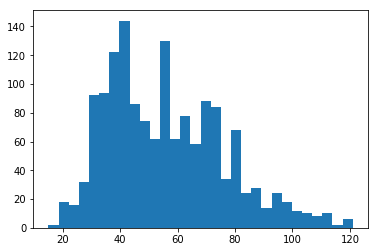

In [37]:
import matplotlib.pyplot as plt
data = list(srav0)
plt.hist(data, bins=30)
plt.show()

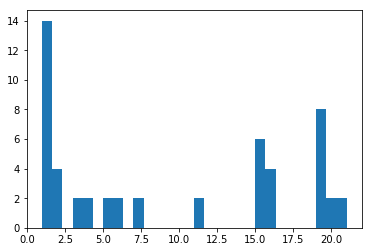

In [38]:
data = list(srav1)
plt.hist(data, bins=30)
plt.show()

In [15]:
for i in dic:
    if i[1] not in ['.',',']:
        print(i[1],[int(evklid(i[0],j[0])) for j in dic if j[1] not in ['.',',']])

srav0=[]
srav1=[]
for i in dic:
    for j in dic:
        if (i[1] not in ['.',',']) and (j[1] not in ['.',',']) and (dic.index(i)!=dic.index(j)):
            if i[1]==j[1]:
                srav1.append(int(evklid(i[0],j[0])))
            else:
                srav0.append(int(evklid(i[0],j[0])))

П [0, 45, 57, 70, 53, 55, 44, 54, 72, 55, 72, 31, 54, 70, 67, 37, 30, 53, 36, 39, 40, 40, 57, 49, 64, 41, 39, 40, 64, 403, 37, 149, 38, 50, 26, 43, 53, 41, 21, 87, 63, 110, 74, 57, 56, 22, 42, 35, 51, 66, 33, 32, 40, 218, 47, 40, 44, 39, 111, 50, 47, 79, 68, 25, 39, 60, 68, 50, 24, 49, 54, 58, 53, 43, 31, 53, 879, 59, 50, 36, 33, 31, 23, 44, 39, 68, 35, 35, 43, 35, 34, 26, 43, 123, 44, 26, 64, 48, 68, 79, 56, 59, 25, 32, 45, 152, 32, 10, 362, 51, 27, 57, 42, 27, 75, 363, 72, 362, 64, 40, 52, 39, 54, 49, 40, 76, 16, 60, 36, 364, 51, 39, 27, 36, 46, 37, 62, 362, 34, 29, 39, 53, 32, 38, 49, 54, 52, 40, 49, 44, 78, 41, 40, 69, 61, 69, 64, 39, 56, 392, 53, 47, 43, 47, 37, 389, 60, 85, 51, 31, 36, 37, 49, 29, 56, 46, 28, 54, 54, 34, 24, 43, 48, 46, 41, 63, 57, 37, 38, 45, 45, 22, 54, 39, 35, 77, 29, 41, 41, 49, 28, 62, 400, 39, 35, 53, 35, 38, 33, 43]
р [45, 0, 71, 84, 63, 65, 69, 74, 79, 28, 101, 20, 73, 49, 42, 48, 61, 69, 55, 29, 69, 67, 75, 69, 94, 71, 64, 58, 72, 370, 56, 151, 49, 71, 5

р [44, 20, 83, 97, 76, 62, 71, 71, 94, 21, 105, 24, 82, 39, 45, 44, 69, 79, 59, 35, 72, 73, 85, 73, 101, 76, 72, 54, 81, 379, 62, 168, 58, 82, 54, 64, 62, 47, 50, 120, 73, 143, 111, 56, 81, 55, 34, 52, 80, 90, 53, 70, 69, 250, 29, 40, 58, 67, 141, 71, 84, 111, 99, 47, 63, 88, 105, 86, 41, 79, 61, 97, 90, 67, 61, 73, 848, 83, 76, 57, 58, 68, 58, 0, 68, 89, 67, 74, 73, 63, 67, 55, 75, 154, 81, 55, 93, 60, 60, 105, 87, 94, 48, 40, 43, 132, 41, 53, 327, 67, 35, 53, 41, 53, 109, 327, 89, 329, 61, 65, 79, 70, 24, 47, 75, 110, 52, 50, 73, 328, 85, 67, 45, 67, 64, 72, 90, 328, 67, 43, 63, 71, 46, 23, 68, 20, 36, 38, 74, 73, 109, 63, 65, 100, 27, 101, 39, 65, 71, 364, 52, 68, 62, 12, 67, 360, 82, 115, 80, 56, 72, 65, 72, 63, 75, 74, 49, 40, 61, 36, 62, 10, 70, 68, 69, 37, 48, 24, 59, 71, 74, 44, 76, 60, 67, 110, 61, 69, 59, 73, 56, 37, 375, 59, 68, 60, 71, 71, 69, 70]
а [39, 62, 36, 46, 32, 63, 34, 56, 48, 72, 54, 51, 32, 93, 85, 48, 32, 19, 30, 46, 23, 10, 25, 39, 41, 24, 31, 46, 47, 407, 17, 

о [39, 68, 61, 59, 50, 42, 12, 33, 68, 69, 42, 49, 43, 81, 75, 33, 44, 48, 20, 57, 14, 40, 57, 23, 49, 33, 47, 23, 49, 430, 31, 138, 51, 57, 18, 29, 63, 36, 40, 61, 73, 76, 57, 60, 41, 28, 50, 57, 56, 69, 25, 42, 23, 204, 51, 37, 35, 12, 75, 24, 27, 46, 40, 45, 20, 26, 48, 49, 37, 49, 46, 41, 27, 39, 33, 37, 907, 53, 33, 17, 28, 43, 31, 67, 34, 62, 21, 31, 49, 24, 39, 41, 51, 90, 32, 26, 65, 35, 64, 70, 44, 60, 41, 48, 69, 185, 48, 33, 389, 24, 46, 74, 49, 38, 43, 390, 59, 390, 79, 12, 56, 27, 68, 51, 22, 45, 27, 57, 31, 390, 61, 0, 40, 21, 28, 45, 49, 389, 39, 37, 34, 36, 34, 51, 19, 68, 68, 42, 42, 43, 49, 37, 41, 35, 72, 36, 74, 29, 39, 418, 52, 15, 34, 66, 41, 415, 52, 53, 33, 26, 27, 30, 27, 37, 40, 40, 34, 70, 44, 39, 34, 67, 15, 45, 43, 72, 57, 49, 28, 17, 50, 31, 33, 20, 33, 50, 32, 45, 23, 50, 23, 72, 427, 18, 38, 40, 25, 25, 43, 47]
И [27, 41, 43, 65, 44, 59, 44, 59, 66, 53, 71, 28, 48, 73, 66, 39, 37, 44, 36, 37, 39, 39, 49, 48, 62, 38, 38, 42, 60, 400, 33, 142, 19, 49, 30, 

я [22, 44, 59, 66, 51, 47, 34, 47, 68, 49, 68, 29, 52, 67, 64, 25, 40, 47, 26, 32, 32, 37, 54, 41, 64, 39, 44, 28, 53, 403, 23, 142, 41, 52, 17, 34, 47, 30, 25, 80, 59, 105, 73, 48, 53, 25, 28, 32, 54, 67, 16, 34, 27, 217, 37, 30, 39, 29, 105, 38, 45, 73, 65, 29, 25, 50, 66, 51, 23, 46, 50, 59, 51, 41, 34, 42, 879, 54, 46, 23, 18, 40, 31, 44, 33, 63, 34, 38, 47, 25, 34, 20, 49, 120, 43, 20, 62, 39, 63, 76, 50, 61, 19, 22, 42, 156, 27, 25, 361, 36, 20, 50, 29, 20, 71, 361, 62, 361, 57, 30, 53, 29, 46, 33, 36, 72, 25, 54, 41, 362, 58, 31, 30, 35, 35, 39, 57, 361, 37, 27, 38, 41, 20, 35, 40, 47, 43, 35, 44, 41, 70, 39, 41, 65, 53, 65, 62, 30, 45, 391, 48, 38, 39, 43, 39, 388, 53, 76, 45, 17, 35, 29, 43, 37, 44, 40, 16, 46, 48, 31, 32, 43, 37, 46, 41, 59, 53, 32, 20, 37, 48, 0, 50, 26, 30, 69, 27, 45, 30, 50, 19, 59, 399, 23, 34, 45, 34, 36, 40, 46]
Гр [54, 84, 91, 90, 79, 48, 42, 39, 98, 79, 62, 65, 72, 83, 87, 46, 68, 79, 50, 75, 46, 66, 87, 48, 75, 60, 72, 37, 74, 448, 59, 166, 78, 84, 

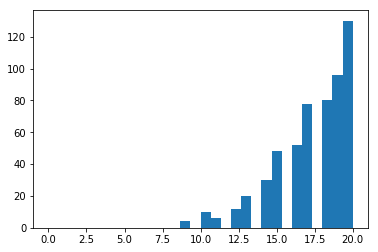

In [28]:
import matplotlib.pyplot as plt
data = list(srav0)
plt.hist(data, bins=30,range=[0, 20])
plt.show()

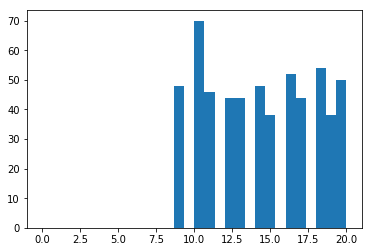

In [29]:
data = list(srav1)
plt.hist(data, bins=30,range=[0, 20])
plt.show()

In [39]:
srav

[[45, False, 'П', 'р'],
 [57, False, 'П', 'и'],
 [70, False, 'П', 'в'],
 [53, False, 'П', 'е'],
 [55, False, 'П', 'т'],
 [44, False, 'П', 'с'],
 [54, False, 'П', 'т'],
 [72, False, 'П', 'в'],
 [55, False, 'П', 'у'],
 [72, False, 'П', 'ю'],
 [31, False, 'П', 'р'],
 [57, False, 'П', 'и'],
 [74, False, 'П', 'в'],
 [54, False, 'П', 'е'],
 [53, False, 'П', 'т'],
 [70, False, 'П', 'Г'],
 [46, False, 'П', 'р'],
 [54, False, 'П', 'е'],
 [67, False, 'П', 'г'],
 [37, False, 'П', 'С'],
 [30, False, 'П', 'п'],
 [53, False, 'П', 'а'],
 [36, False, 'П', 'с'],
 [57, False, 'П', 'и'],
 [39, False, 'П', 'б'],
 [40, False, 'П', 'о'],
 [40, False, 'П', 'з'],
 [57, False, 'П', 'а'],
 [49, False, 'П', 'к'],
 [40, False, 'П', 'о'],
 [64, False, 'П', 'м'],
 [30, False, 'П', 'п'],
 [41, False, 'П', 'л'],
 [57, False, 'П', 'и'],
 [63, False, 'П', 'м'],
 [54, False, 'П', 'е'],
 [39, False, 'П', 'н'],
 [54, False, 'П', 'т'],
 [45, False, 'р', 'П'],
 [71, False, 'р', 'и'],
 [84, False, 'р', 'в'],
 [63, False, 'р'

In [41]:
dic

[[[45.0, 45.0, 30.0, 30.0, 20.4545, 54.5455, 34.0, 30.0, 140.0], 'П'],
 [[47.3214, 44.6429, 23.2143, 48.2143, 31.4484, 38.6905, 40.8929, 27.5, 175.0],
  'р'],
 [[40.0, 65.0, 40.0, 65.0, 36.6667, 68.3333, 55.3409, 49.6591, 125.0], 'и'],
 [[66.6667, 48.8889, 50.0, 60.0, 52.3333, 48.5556, 56.2626, 59.1919, 111.1111],
  'в'],
 [[52.5, 57.5, 37.5, 51.25, 49.3056, 47.9167, 61.8182, 45.7955, 125.0], 'е'],
 [[47.5, 38.75, 12.5, 25.0, 50.4167, 17.3611, 27.6136, 18.75, 125.0], 'т'],
 [[40.0, 33.3333, 32.2222, 40.0, 37.1111, 33.7778, 29.1919, 43.1313, 111.1111],
  'с'],
 [[45.5556,
   44.4444,
   22.2222,
   22.2222,
   47.1111,
   19.6667,
   30.404,
   22.2222,
   111.1111],
  'т'],
 [[68.75, 51.25, 52.5, 62.5, 54.1667, 52.5, 58.8636, 62.3864, 125.0], 'в'],
 [[36.6071, 37.5, 13.3929, 34.8214, 40.1786, 22.619, 36.6667, 23.0357, 175.0],
  'у'],
 [[50.7692,
   36.9231,
   36.9231,
   45.3846,
   42.1429,
   42.0879,
   44.8252,
   41.5385,
   76.9231],
  'ю'],
 [[100.0, 75.0, 75.0, 75.0, 91.6667, 

In [1]:
x=input()
print(x)

kkk
kkk


In [17]:
dic=dic_refresh()

In [18]:
dic

[]

In [21]:
len(dic)

0

In [36]:
for ii in range(1,50):
    for jj in range(1,50):
        #print(str(sum(pix[ii, jj])),end='') # рисуем для визуального определения
        print(sum(pix[ii, jj]))
    print('',sep=' ')

TypeError: 'numpy.int32' object is not iterable

In [92]:
import pyautogui
import time


#pyautogui.keyUp('space')
#pyautogui.keyUp('left windows')
#pyautogui.hotkey('alt', 'tab') # не работает

pyautogui.keyDown('alt')
pyautogui.press('tab')
pyautogui.keyUp('alt')

# перемещение мышки
#x, y = 1, 1
#pyautogui.moveTo(x, y)
#pyautogui.click()

In [9]:
strok=(pix.sum(axis=0)>0)
#(strok>0)[300:].argmax() # а критерий остановки сделать, если max = 0


In [71]:
x.argmax()

3

In [46]:
def argmaxmax(array):
    z=0
    ar=array.max()
    for i in range(1,array.shape[0]):
        if x[-i]=ar: z=i

array([], dtype=int32)

In [76]:
x=np.array([0,0,1,1,1,1,0,0,1,1,0])
print(x.argmax())
print(argmaxmax(x))

2
9


In [7]:
x=datetime.datetime.now()
x.hour

11

In [12]:
x

datetime.datetime(2020, 1, 21, 11, 26, 1, 804736)

In [15]:
x+datetime.timedelta(minutes=30)

datetime.datetime(2020, 1, 21, 11, 56, 1, 804736)

In [45]:
y=datetime.datetime.now()

In [67]:
print(x)
print(y)
str(y-x)[:-3]

2020-01-21 11:38:35.628852
2020-01-21 13:40:31.505296


'2:01:55.876'

In [68]:
x=datetime.datetime.now()

In [73]:
print(y)
print(x)
'0'+str(x-y)[:-3].replace('.',',')

2020-01-21 13:40:31.505296
2020-01-21 13:59:29.762401


'00:18:58,257'

In [74]:
8/2*(2+2)

16.0

In [96]:
fact=np.array([30.7692,  36.9231 , 37.9487 , 31.2821 , 33.3333,  31.5018 , 37.5 , 31.0897 , 115.3846])

In [97]:
fact

array([ 30.7692,  36.9231,  37.9487,  31.2821,  33.3333,  31.5018,
        37.5   ,  31.0897, 115.3846])

In [98]:
dict=np.array([35.7143 ,39.2857, 39.2857, 33.9286 ,38.1696, 35.7143 ,39.6825 ,34.127, 114.2857])

In [100]:
evklid(fact,dict)

9.754919615763116

In [6]:
x='123_44 55 66'

In [2]:
x

'1_44 55 66'

In [3]:
x.index('_')

1

In [8]:
int(x[:x.index('_')])

123

In [10]:
x=datetime.datetime.now()

In [11]:
x

datetime.datetime(2020, 1, 22, 10, 52, 41, 484698)

In [13]:
y=datetime.datetime(2020,1,22,10,52,41,567890)

In [14]:
y

datetime.datetime(2020, 1, 22, 10, 52, 41, 567890)

{}
{10000: ['e07/10000_18 46 54 224.jpg', '18 46 54 224'], 10001: ['e07/10001_18 46 54 319.jpg', '18 46 54 319'], 10002: ['e07/10002_18 46 54 399.jpg', '18 46 54 399'], 10003: ['e07/10003_18 46 54 480.jpg', '18 46 54 480'], 10004: ['e07/10004_18 46 54 571.jpg', '18 46 54 571'], 10005: ['e07/10005_18 46 54 678.jpg', '18 46 54 678'], 10006: ['e07/10006_18 46 54 804.jpg', '18 46 54 804'], 10007: ['e07/10007_18 46 54 906.jpg', '18 46 54 906'], 10008: ['e07/10008_18 46 55 1.jpg', '18 46 55 1'], 10009: ['e07/10009_18 46 55 80.jpg', '18 46 55 80'], 1000: ['e07/1000_18 33 30 866.jpg', '18 33 30 866'], 10010: ['e07/10010_18 46 55 171.jpg', '18 46 55 171'], 10011: ['e07/10011_18 46 55 273.jpg', '18 46 55 273'], 10012: ['e07/10012_18 46 55 368.jpg', '18 46 55 368'], 10013: ['e07/10013_18 46 55 447.jpg', '18 46 55 447'], 10014: ['e07/10014_18 46 55 517.jpg', '18 46 55 517'], 10015: ['e07/10015_18 46 55 617.jpg', '18 46 55 617'], 10016: ['e07/10016_18 46 55 699.jpg', '18 46 55 699'], 10017: ['e07/1

In [13]:
import os
 
dic_name='dict_kinopoisk.txt'
    
dir_name = "snl s46e10/"
fname='snl s46e10.srt'













# начальный субтитр
i=43077
i_break=1116600

# опознавать новые символы сразу или потом - 1|0
realtimerecognize=1

# длина шага
step_full=8

test = os.listdir(dir_name)
images = filter(lambda x: x.endswith('.jpg'), test)
sp={}
for item in images:
    sp[int(item[:item.index('_')])]=[dir_name+item,item[(item.index('_')+1):(item.index('.'))]]

dic,dicl=dic_refresh_vect(dic_name) # потом возьмём как глобальные, т.к. нужно их обновлять
#print('Объём словаря - ',len(dic))

xxx=datetime.datetime.now()


#while recognize_str_new(topix(sp[i][0])).replace(' ','').replace('\n','')=='': # ищем первый текст
    #print(sp[i][0])
#    i+=1
if i<500:    # если начальный субтитр большой - видимо, продолжаем запись в файл и обнулять его не надо
    f = open(fname, 'w') # запись
    f.write('')
    f.close()

nach=i
curr_text=recognize_str_new(topix(sp[i][0]),dic_name,realtimerecognize)
c_text=curr_text.replace(' ','').replace('\n','').replace('.','').lower()[:10] 

step=step_full
i=nach+step

print('начало ',nach)
while i<len(sp) and i<i_break:
    i_text=recognize_str_new(topix(sp[i][0]),dic_name,realtimerecognize,words_count=14,ind=i).replace(' ','').replace('\n','').replace('.','').lower()[:10] # в начале, т.к. в конце шаг может перейти пределы словаря
    #c_text=curr_text.replace(' ','').replace('\n','').replace('.','').lower()[:3] 
    #print('шаг ',i,step)
    if abs(step)==1: # нашли точку смены текста
        if i_text==c_text:
            print('конец ',i)
            print(curr_text.replace(' ','').replace('\n',''))
            if curr_text!='':
                f = open(fname, 'a') # дозапись
                f.write(str(round(nach))+'\n')
                f.write('0'+str(todate(sp[nach][1])-todate(sp[1][1])-(todate(sp[nach][1])-todate(sp[nach-1][1]))/2).replace('.',',')[:-3])
                f.write(' --> ')
                f.write('0'+str(todate(sp[i+1][1])-todate(sp[1][1])-(todate(sp[i+1][1])-todate(sp[i][1]))/2).replace('.',',')[:-3])
                f.write('\n')
                f.write(curr_text)
                f.write('\n')
                f.close()
            
            nach=i+1
            
            #print('Объём словаря - ',len(dic))
            
            print('начало ',nach)
            
            curr_text=recognize_str_new(topix(sp[i+1][0]),dic_name,realtimerecognize)
            c_text=curr_text.replace(' ','').replace('\n','').replace('.','').lower()[:10] 
            #print(curr_text.replace(' ','').replace('\n',''))
            
        else:
            print('конец ',i-1)
            print(curr_text.replace(' ','').replace('\n',''))
            if curr_text!='':
                f = open(fname, 'a') # дозапись
                f.write(str(round(nach))+'\n')
                f.write('0'+str(todate(sp[nach][1])-todate(sp[1][1])-(todate(sp[nach][1])-todate(sp[nach-1][1]))/2).replace('.',',')[:-3])
                f.write(' --> ')
                f.write('0'+str(todate(sp[i][1])-todate(sp[1][1])-(todate(sp[i][1])-todate(sp[i-1][1]))/2).replace('.',',')[:-3])
                f.write('\n')
                f.write(curr_text)
                f.write('\n')
                f.write('\n')
                f.close()
            nach=i
            
            #print('Объём словаря - ',len(dic))
            
            print('начало ',nach)
            
            curr_text=recognize_str_new(topix(sp[i][0]),dic_name,realtimerecognize)
            c_text=curr_text.replace(' ','').replace('\n','').replace('.','').lower()[:10] 
            #print(curr_text.replace(' ','').replace('\n',''))
        step=step_full
    elif i_text==c_text:
        if step<step_full: step=abs(step)/2 # если при скачке обнаруживаем тот же текст и уже вошли в режим деления - делим пополам
    elif i_text!=c_text:
        step=-abs(step)/2 # если произошёл перескок - двигаемся назад
    i+=step
yyy=datetime.datetime.now()

print(yyy-xxx)

начало  43077
43093 69 78 1190 1198
  xxxxxxx              xx                       
  xxxxxxxx           xxxxxx                     
   xxxxxxx          xxxxxxxx                    
    xxxxxxx         xxxxxxxx                    
    xxxxxxx         xxxxxxxx                    
     xxxxxxx        xxxxxxxx                    
      xxxxxxx       xxxxxxx                     
      xxxxxxxx       xxxxx                      
        xxxxxx        xxx                       
.
конец  43090.0
Да!
начало  43091.0
конец  43206.0
Снесетихптицаодвухногах.Апользасамаявжелтках.
начало  43207.0
конец  43233.0
Яйца!
начало  43234.0
конец  43234.0

начало  43235.0
конец  43263.0
Молодцы,КрисиДжина.
начало  43264.0
конец  43305.0
-Люблютебя.-Тымойкороль.
начало  43306.0
конец  43306.0

начало  43307.0
конец  43357.0
Чистодружескийпоцелуй.Вау!Яйцаприносят
начало  43358.0
конец  43407.0
бонусвстодолларов.Джина,найдитеяйца!
начало  43408.0
конец  43408.0

начало  43409.0
конец  43435.0
-Бегу!Всерадитеб

»
43814.0 124 145 947 969
                           xxxx       xxx         xxxxxx      
                          xxxxx      xxxx         xxxxxx      
                          xxxx      xxxxx         xxxxxx      
                         xxxxx      xxxx          xxxxxx     x
                        xxxxx      xxxx           xxxxxx    xx
                        xxxx      xxxxx           xxxxxx   xxx
                       xxxxx     xxxxx            xxxxxx   xxx
                      xxxxx     xxxxx             xxxxxx xxxxx
                     xxxxx      xxxxx             xxxxxxxxxxxx
                     xxxxx     xxxxx              xxxxxxxxxxxx
                    xxxxx      xxxxx              xxxxxxxxxxxx
                     xxxxx     xxxxx              xxxxxxxxxxxx
                     xxxxx      xxxxx             xxxxxx  xxxx
                      xxxxx     xxxxx             xxxxxx   xxx
                       xxxxx     xxxxx            xxxxxx    xx
                        xxxx 

Р
конец  44772.0
прошлыхпередач.ЭтоСэмиКорин.ДжениРебекка.КеллииРоан.ИЭллениПорша.
начало  44773.0
конец  44851.0
КрисиДжина,выведете,азначитвасждетмини-чистка.Еслинайдете
начало  44852.0
конец  44930.0
золотуючерникусособымзнаком,nолучитепятьтысячдолларов.Готовы?
начало  44931.0
конец  44958.0
Радитебяяготованавсё.
начало  44959.0
конец  44959.0

начало  44960.0
конец  45005.0
Спасибозасегодня,завседнивбудущем
начало  45006.0
конец  45044.0
ивседни,чтомыпровелистобойвместе.
начало  45045.0
45076.0 109 149 684 713
                    xxxxxxxxxxxxxxxxxxxxxxxxx                        
                    xxxxxxxxxxxxxxxxxxxxxxxxx                        
                    xxxxxxxxxxxxxxxxxxxxxxxxx                        
                    xxxxxxxxxxxxxxxxxxxxxxxxx                        
                    xxxxxxxxxxxxxxxxxxxxxxxxx                        
                    xxxxxxx                                          
                    xxxxxxx                                 

Т
конец  45216.0
Нет,нет.Ятебянеоставлю.
начало  45217.0
конец  45243.0
-Тыдолжна.-Чертасдва!
начало  45244.0
конец  45244.0

начало  45245.0
конец  45272.0
Осталосьсороксекунд!
начало  45273.0
конец  45320.0
Посмотринаменя.Тыдляменявсё.Ивсеослы,
начало  45321.0
конец  45372.0
которыхмывыкормилибутылкой,считаюттебяматерью.
начало  45373.0
конец  45373.0

начало  45374.0
конец  45402.0
-Двадцатьсекунд.-Завали!
начало  45403.0
45482.0 37 78 710 718
 xxxxx                x                         
xxxxx                xxxxxxx                    
xxxxx                xxxxxxx                    
xxxx                 xxxxxxx                    
xx                   xxxxxxx                    
                     xxxxxxx                    
                     xxxxxx                     
                     xxxxxx                     
                     xxxxxx                     
                     xxxxxx                     
                     xxxxxx                     
     xxxxx

                     xxxxxx                   xxxxxxx        xxxxxxx     
                     xxxxxx                   xxxxxxx        xxxxxx      
                     xxxxxx                   xxxxxxx       xxxxxxx      
                     xxxxxx                   xxxxxxx       xxxxxxx      
                     xxxxxx                   xxxxxxx       xxxxxx       
                     xxxxxx                   xxxxxxx       xxxxxx       
                     xxxxxx                   xxxxxxx       xxxxxx       
                     xxxxxx                   xxxxxxx       xxxxxx       
                     xxxxxx                   xxxxxxx       xxxxxx       
                     xxxxxx                   xxxxxxx       xxxxxxx      
                     xxxxxx                   xxxxxxx       xxxxxxx      
                     xxxxxx                   xxxxxxx       xxxxxxx      
                     xxxxxx                   xxxxxxx        xxxxxxx     
                     xxxxxx           

     xxxxxxx        xxxxxxxxxxxxxxxxxxxxxxxxxxx        xxxxxx         
     xxxxxx         xxxxxxxxxxxxxxxxxxxxxxxxxxx        xxxxxx         
     xxxxxx         xxxxxxxxxxxx       xxxxxxxxx       xxxxxxx        
     xxxxxx         xxxxxxxxxx          xxxxxxxx        xxxxxx        
     xxxxxx         xxxxxxxx             xxxxxxxx       xxxxxx        
     xxxxxx         xxxxxxxx              xxxxxxx       xxxxxx        
     xxxxxx         xxxxxxx                xxxxxx        xxxxxx       
     xxxxxx         xxxxxxx                xxxxxxx       xxxxxx       
     xxxxxx         xxxxxxx                xxxxxxx       xxxxxxx     x
     xxxxxx         xxxxxxx                 xxxxxx       xxxxxxx     x
     xxxxxx         xxxxxx                  xxxxxx       xxxxxxx     x
     xxxxxx         xxxxxx                  xxxxxx        xxxxxx     x
     xxxxxxx        xxxxxx                  xxxxxx        xxxxxx    xx
     xxxxxx         xxxxxxx                 xxxxxx        xxxxxxx   xx
     x

                    xxxxxxx                   xxxxxxx        xxxxxxxxx   
                    xxxxxxx                   xxxxxxx         xxxxxxx    
                    xxxxxxx                   xxxxxxx        xxxxxxxx    
                    xxxxxxx                   xxxxxxx        xxxxxxx     
                    xxxxxxx                   xxxxxxx        xxxxxxx     
                    xxxxxxx                   xxxxxxx        xxxxxxx     
                    xxxxxxx                   xxxxxxx        xxxxxxx     
                    xxxxxxx                   xxxxxxx        xxxxxxx     
                    xxxxxxx                   xxxxxxx         xxxxxx     
                    xxxxxxx                   xxxxxxx        xxxxxxx     
                    xxxxxxx                   xxxxxxx        xxxxxxx     
                    xxxxxxx                   xxxxxxx        xxxxxxx     
                    xxxxxxx                   xxxxxxx        xxxxxxxx    
                    xxxxxxx           

                               xxxxxxxx            xxxxxxx             xxxxxxx       xxxxxx       
                               xxxxxxxx            xxxxxxxx            xxxxxx        xxxxxx       
                               xxxxxxxx             xxxxxxxxx        xxxxxxxx        xxxxxx       
                               xxxxxxx               xxxxxxxxxxxxxxxxxxxxxxx         xxxxxx       
                               xxxxxxx               xxxxxxxxxxxxxxxxxxxxxxx         xxxxxx       
                               xxxxxxxx                xxxxxxxxxxxxxxxxxxx           xxxxxx       
                               xxxxxxxx                 xxxxxxxxxxxxxxxxx            xxxxxx       
                               xxxxxxxx                   xxxxxxxxxxxxx              xxxxxx       
                                xxxxxx                       xxxxxxxx                xxxxx        
Те
конец  47066.0
-Любопытно.-Так-так.
начало  47067.0
47068.0 48 78 770 801
       xxxxxx                 xx

!
конец  47683.0
Вотименно!Мынашлисокровище!Мынепростовпариваемсэндвичи.Мы
начало  47684.0
конец  47773.0
рассказываемисторию.Мыпродавалисэндвичи,рассказываяисториюДжареда.
начало  47774.0
конец  47842.0
Subwаупойдетвногусовременемнерадимясноймиски,арадиистории.
начало  47843.0
конец  47843.0

начало  47844.0
конец  47871.0
Допустим,ичтовыпредлагаете?
начало  47872.0
конец  47914.0
-ВернутьДжареда.-Да.
начало  47915.0
конец  47915.0

начало  47916.0
конец  47995.0
Нет.Прекратите.Рокки,Дино,мыникогданевернем
начало  47996.0
конец  48074.0
Джареда.Мывамобэтомужеговорили.Онпедофил.
начало  48075.0
48139.0 37 78 607 637
                                   xx x                               
                            xxxxxxxxxxxxx                             
                          xxxxxxxxxxxxxxxxxx                          
                        xxxxxxxxxxxxxxxxxxxxxx                        
                       xxxxxxxxxxxxxxxxxxxxxxx                        
                     

  xxxxxxxxx          xxxxxxxx       xxxxxxxxxx         xxxxxxxxxxxx
xxxxxxxxxxx          xxxxxxxxxxxxxxxxxxxxxxxxx         xxxxxxxxxxxx
xxxxxxxxxx            xxxxxxxxxxxxxxxxx xxxxxx         xxxxxxxxxxxx
xxxxxxxx               xxxxxxxxxxxxxx   xxxxxxx        xxxxxx   xxx
xxxxxx                  xxxxxxxxxxxx    xxxxxx         xxxxxx     x
xxxx                      xxxxxxxx      xxxxxx         xxxxxx      
u
конец  48334.0
Иеслихочешьсэндвич,ВSubwаускорейбегиты.
начало  48335.0
конец  48335.0

начало  48336.0
конец  48372.0
Еслиестьпятьбаксов,Тотытамкупишьсэндвич.
начало  48373.0
конец  48419.0
Нобезпеченюхи,Безчипсовинапитка.
начало  48420.0
0 109 149 625 669
                                       xxxxxx                                       
                                      xxxxxxx                                       
                                       xxxxxx                                       
                                       xxxxxx                                 

     xxxxxx         xxxxxxxxxx          xxxxxxx                    
     xxxxxx         xxxxxxxxx           xxxxxx                     
     xxxxxx         xxxxxxxxx           xxxxxx                     
     xxxxxx         xxxxxxxx            xxxxxx                     
     xxxxxx         xxxxxxxx            xxxxxxx                    
     xxxxxx         xxxxxxx             xxxxxx                     
      xxxxx          xxxxx               xxxxx                     
и
конец  48604.0

начало  48605.0
конец  48674.0
Привсемуважении,еслибудетепродаватьмясныемиски,явздернусь.
начало  48675.0
конец  48675.0

начало  48676.0
48692.0 69 78 609 617
        xxxxxx          xx                      
       xxxxxx        xxxxxx                     
     xxxxxxxx        xxxxxxx                    
xxxxxxxxxxxx        xxxxxxxx                    
xxxxxxxxxxxx        xxxxxxxx                    
xxxxxxxxxxx         xxxxxxxx                    
xxxxxxxxx            xxxxxxx                    
xxx

|
конец  48972.0
Потомучтовыпригрозилисамоубийством.
начало  48973.0
48989.0 109 149 1357 1366
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
                     xxxxxxx                     
     xxxxxx          xxxxxxx                     
     xxxxxx          xxxxxxx                     
     xxxxxx          xxxxxxx                     
     xxxxxx          xxxxxxx                     
     xxxxxx          xxxxxxx                     
     xxxxxx          xxxxxxx                     
     xxxxxx          xxxxxxx                     
     

                                         xxxxx                     xxxxxx                    
                                         xxxxx                     xxxxxx                    
                                         xxxxx                     xxxxxx                    
                                         xxxxx                      xxxxx                    
                                         xxxxx                      xxxxx                    
гд
конец  49556.0
Привет.МенязовутРататуй.
начало  49557.0
конец  49625.0
Онмнойуправляет,когдамычпокаемся.Этоегозаслуга.
начало  49626.0
конец  49626.0

начало  49627.0
конец  49653.0
Янепонимаю.
начало  49654.0
конец  49654.0

начало  49655.0
конец  49696.0
Яобъясню.Давным-давноянаучился
начало  49697.0
конец  49750.0
великолепноготовить,прочитавкулинарную
начало  49751.0
конец  49803.0
книгуоткоркидокорки.Нопотомянашел
начало  49804.0
0 120 149 871 895
        xxxxxx             xxxxxxxxxxx          xxxxxxxxxxxxxxxx
     

                     xxxxxxxxxxxxxxxxxx                               xxxx
D
0 109 149 400 435
xx                  xxxxxxx                      xxxxxx        xxxxxxxxxxxx
xxxxx               xxxxxxxx                     xxxxxx       xxxxxxxxxxxxx
xxxxxxxx             xxxxxxx                    xxxxxxx       xxxxxxxxxxxxx
xxxxxxxxx            xxxxxxx                    xxxxxx        xxxxxxxxxxxxx
xxxxxxxxxx           xxxxxxxx                   xxxxxx        xxxxxxxxxxxxx
xxxxxxxxxxxx          xxxxxxx                  xxxxxxx        xxxxxxxx     
  xxxxxxxxxx          xxxxxxx                  xxxxxx         xxxxxxx      
    xxxxxxxxx         xxxxxxx                  xxxxxx         xxxxxxx      
     xxxxxxxxx        xxxxxxxx                xxxxxxx         xxxxxxx      
      xxxxxxxxx        xxxxxxx                xxxxxx          xxxxxxx      
       xxxxxxxx        xxxxxxx               xxxxxxx          xxxxxxx      
        xxxxxxx         xxxxxxx              xxxxxxx          xxxxxxx

И
конец  50515.0
взглядаопределяюдиск:DVD,Вlu-rауилииградляРS2.
начало  50516.0
конец  50541.0
Ичастоэтонадоделать?
начало  50542.0
конец  50542.0

начало  50543.0
конец  50571.0
Неповеришь.Никогда.
начало  50572.0
конец  50656.0
Значит,тынамбольшененужна.
начало  50657.0
конец  50658.0

начало  50659.0
конец  50729.0
Шпыняюткакблохупоследнюю!
начало  50730.0
50737.0 120 149 993 1033
     xxxxxxx        xxxxxxx         xxxxxxx          xxxxxx        xxxxxxx      
     xxxxxxx        xxxxxxx         xxxxxxx          xxxxxx        xxxxxxx      
    xxxxxxxx         xxxxxx         xxxxxxx          xxxxxx        xxxxxxx      
    xxxxxxxx         xxxxxx         xxxxxxx          xxxxxx        xxxxxxx      
   xxxxxxxxx         xxxxxx         xxxxxxx          xxxxxx        xxxxxxx      
  xxxxxxxxxx         xxxxxx         xxxxxxx          xxxxxx        xxxxxxx      
  xxxxxxxxxx         xxxxxx         xxxxxxx          xxxxxx        xxxxxxx      
 xxxxxxxxxxx         xxxxxx         xxxxxxx   

                     xxxxxx             xxxxxx         xxxxxxxxx  
                     xxxxxx            xxxxxxx         xxxxxxxxxxx
                     xxxxxx            xxxxxxx          xxxxxxxxxx
                     xxxxxx            xxxxxxx            xxxxxxxx
                     xxxxxx             xxxxxx              xxxxxx
                     xxxxxx             xxxxxx                xxxx
                     xxxxx              xxxxx                    x
п
конец  50758.0
Тыменяещелюбишь?
начало  50759.0
конец  50759.0

начало  50760.0
конец  50814.0
Толькопообещайодно.Неотпускайэтукрысу.
начало  50815.0
конец  50815.0

начало  50816.0
конец  50886.0
Идет.Эй,Рататуй!Начинайдергать.
начало  50887.0
50935.0 120 149 861 888
xxxxxxxxxxx         xxxxxxx            xxxxxxxx         xxxxxx     
xxxxxxxxxxx         xxxxxxx            xxxxxxxx         xxxxxx     
xxxxxxxxxxx         xxxxxx            xxxxxxxxx         xxxxxx     
xxxxxxxxxxx         xxxxxx            xxxxxxxxx         

                     xxxxxx          xxxxxxxxx         xxxxxxx         
                     xxxxxx           xxxxxxxx         xxxxxxxx        
                     xxxxxx            xxxxxxxx         xxxxxxxxx      
                     xxxxxx             xxxxxxxx        xxxxxxxxxxxxxxx
                     xxxxxx             xxxxxxxxx         xxxxxxxxxxxxx
                     xxxxxx               xxxxxxxx         xxxxxxxxxxxx
                    xxxxxxx               xxxxxxxxx          xxxxxxxxxx
                     xxxxxx                xxxxxxxx            xxxxxxxx
К
конец  51414.0

начало  51415.0
конец  51449.0
Конец
начало  51450.0
конец  51647.0

начало  51648.0
конец  51723.0
ПосвящаетсяСиселиТайсон
начало  51724.0
конец  51755.0

начало  51756.0
51819.0 48 78 909 936
    xxxxxxx         xxxxxx       xxxxxxx                       xxxx
    xxxxxxx         xxxxxx     xxxxxxxxxxx                   xxxxxx
    xxxxxxx         xxxxxx   xxxxxxxxxxxxxxx               xxxxxxxx
    xxxx

In [3]:
import os
 
dir_name = "snl s46e10/"
test = os.listdir(dir_name)
images = filter(lambda x: x.endswith('.jpg'), test)
sp={}
for item in images:
    sp[int(item[:item.index('_')])]=[dir_name+item,item[(item.index('_')+1):(item.index('.'))]]

In [6]:
dic_name='dict_kinopoisk.txt'
    
dic,dicl=dic_refresh_vect(dic_name)

recognize_str_new(topix(sp[948][0]),dic_name,1,otladka=1)

{0: [0, 0], 37: [41, 8530], 120: [40, 5256]}
п X870 [ 69.2308  65.1282  47.1795  52.8205  42.0147  74.9451  56.891   49.7756
 115.3846] 48 78 445 471
                    xxxxxxxxxxxxxxxxxxxxxxxxx                  xxx
                    xxxxxxxxxxxxxxxxxxxxxxxxxx               xxxxx
                    xxxxxxxxxxxxxxxxxxxxxxxxxx             xxxxxxx
                    xxxxxxxxxxxxxxxxxxxxxxxxxx           xxxxxxxxx
                    xxxxxxxxxxxxxxxxxxxxxxxxxx          xxxxxxxxxx
                    xxxxxxx            xxxxxxx          xxxxxxxx  
                    xxxxxxx            xxxxxxx         xxxxxxxx   
                    xxxxxxx            xxxxxxx        xxxxxxx     
                    xxxxxxx             xxxxxx        xxxxxxx     
                    xxxxxxx             xxxxxx        xxxxxx      
                    xxxxxxx             xxxxxx       xxxxxxx      
                    xxxxxxx             xxxxxx       xxxxxx       
                    xxxxxxx             xxxxxx

 xxxxxx                                xxxxxxx        xxxxxx      
 xxxxxx                                xxxxxxx        xxxxxx      
 xxxxxx                                xxxxxxx        xxxxxx      
 xxxxxx                      xxxxxxxxxxxxxxxxx        xxxxxxxxxxxx
 xxxxxx                   xxxxxxxxxxxxxxxxxxxx        xxxxxxxxxxxx
 xxxxxx                xxxxxxxxxxxxxxxxxxxxxxx        xxxxxxxxxxxx
 xxxxxx               xxxxxxxxxxxxxxxxxxxxxxxx        xxxxxxxxxxxx
 xxxxxx              xxxxxxxx          xxxxxxx        xxxxxxxxxxxx
 xxxxxx              xxxxxx            xxxxxxx        xxxxxxx     
 xxxxxx             xxxxxxx            xxxxxxx        xxxxxx      
 xxxxxx             xxxxxx             xxxxxxx        xxxxxx      
 xxxxxx             xxxxxx             xxxxxxx        xxxxxx      
 xxxxxx             xxxxxx            xxxxxxxx        xxxxxx      
 xxxxxx             xxxxxxx           xxxxxxxx        xxxxxx      
 xxxxxx             xxxxxxxx        xxxxxxxxxx        xxxxxx  

         xxxxxxx     xxxxxxx               xxxxxxx                     
         xxxxxxx      xxxxxxx             xxxxxxx                      
        xxxxxxx       xxxxxxxx           xxxxxxxx                      
       xxxxxxxx        xxxxxxxxx       xxxxxxxxx                       
xxxxxxxxxxxxxxx        xxxxxxxxxxxxxxxxxxxxxxxx                        
xxxxxxxxxxxxxx          xxxxxxxxxxxxxxxxxxxxxx                         
xxxxxxxxxxxxxx            xxxxxxxxxxxxxxxxxxx                          
xxxxxxxxxxxxx              xxxxxxxxxxxxxxxxx                           
xxxxxxxxxx                    xxxxxxxxxxx                              
xxxxxxxxx                       xxxxxxx                                
ч X1099 [ 51.7949  53.8462  55.3846  18.9744  28.0952  73.8095  57.8846  26.5705
 115.3846] 48 78 741 766
xxxx                xxxxxx             xxxxxx         xxxxxx     
xxxxxxx             xxxxxx             xxxxxx         xxxxxx     
xxxxxxxxx           xxxxxx             xxx

      xxxxxx          xxxxx                      
       xxxxx           xxx                       
У X113 [ 41.9643  37.7976  19.9405  38.0952  47.6716  24.4923  40.6385  26.7045
 131.25  ] 37 78 900 932
                    x x  x                     x                        
                    xxxxxxx                   xxxxxx                    
                     xxxxxxx                 xxxxxxx                    
                     xxxxxxx                 xxxxxxx                    
                      xxxxxxx               xxxxxxx                     
                      xxxxxxx               xxxxxx                      
                       xxxxxxx              xxxxxx                      
                       xxxxxxx             xxxxxx                       
                       xxxxxxx             xxxxxx                       
                        xxxxxxx           xxxxxxx                       
                        xxxxxxx           xxxxxx                 

         xxxxxx              xxxxxxx                     xxxxxxxx
          xxxx                 xxxxx                        xxxxx
е X709 [ 60.4444  60.8889  43.1111  52.8889  56.6389  50.9167  66.3056  49.8056
 100.    ] 48 78 1028 1057
xxxxxxxxxxxxxxxxx             xxxxxxxxxx                   xxxxxxxxxx
xxxxxxxxxxxxxxxxx           xxxxxxxxxxxxxx                 xxxxxxxxxx
xxxxxxxxxxxxxxxxx         xxxxxxxxxxxxxxxxxx               xxxxxxxxxx
xxxxxxxxxxxxxxxxx        xxxxxxxxxxxxxxxxxxxx              xxxxxxxxxx
xxxxxxxxxxxxxxxxx       xxxxxxxxxxxxxxxxxxxxxx             xxxxxxxxxx
 xxxxxxx               xxxxxxxxx       xxxxxxx             xxxxx     
  xxxxxx              xxxxxxxx          xxxxxxx           xxxxxx     
 xxxxxxx              xxxxxxx            xxxxxx           xxxxxx     
 xxxxxxx             xxxxxxx              xxxxxx          xxxxxx     
 xxxxxxx             xxxxxx               xxxxxx           xxxxx     
 xxxxxxx             xxxxxx                xxxxxx         xxx

                    xxxxxx             xxxxxx        xxxxxx    xx
                    xxxxxx             xxxxxx        xxxxxxx    x
                    xxxxxx            xxxxxxx        xxxxxxx     
                    xxxxxx            xxxxxxx        xxxxxx      
                    xxxxxxx          xxxxxxxx        xxxxxx      
                    xxxxxxxx       xxxxxxxxxx        xxxxxxx     
                    xxxxxxxxxxxxxxxxxxxxxxxxx        xxxxxx      
                     xxxxxxxxxxxxxxxxxxxxxxxx        xxxxxxx     
                      xxxxxxxxxxxxxx   xxxxxx        xxxxxx      
                       xxxxxxxxxxxx    xxxxxx        xxxxxxx     
                         xxxxxxxx      xxxxxx        xxxxxxx     
к X49 [ 69.2308  36.9231  45.1282  63.0769  52.0879  32.2344  54.2949  53.4295
 115.3846] 120 149 614 639
xxxxxx              xxxxxxx          xxxxxxx    xxxxxxxxxxxxxxxxx
xxxxxxxx            xxxxxxx          xxxxxx     xxxxxxxxxxxxxxxxx
xxxxxxxxxx          xxxxxxx         

                    xxxxxx                                            
                    xxxxxx                                            
                    xxxxxx                                            
                    xxxxxx                                            
                    xxxxxx                                            
                    xxxxxx                                            
                    xxxxxx                                            
ь X897 [ 65.5556  21.1111  66.6667  71.1111  53.5043  45.0427  55.7292  72.2222
 125.    ] 120 149 742 765
xxxxx               xxxxxx                     xxxxxxx         
xxxxxxx             xxxxxx                     xxxxxxx         
xxxxxxxxx           xxxxxx                     xxxxxxx         
xxxxxxxxxx          xxxxxx                     xxxxxxx         
xxxxxxxxxxx         xxxxxx                     xxxxxxx         
  xxxxxxxxx         xxxxxx                     xxxxxxx         
    xxxxxxxx

                    xxxxxx                     xxxxx                    
                    xxxxx                      xxxxx                    
                    xxxxx                      xxxxx                    
е X42 [ 64.2857  62.381   41.9048  57.619   57.5873  52.6667  68.631   53.125
 107.1429] 120 149 893 921
xxxxxxxxxxxx                 xxxxxxxxxxx            xxxxxxxxxxxxxxxx
xxxxxxxxxxxx               xxxxxxxxxxxxxxx          xxxxxxxxxxxxxxxx
xxxxxxxxxxxx             xxxxxxxxxxxxxxxxxx         xxxxxxxxxxxxxxxx
xxxxxxxxxxxx            xxxxxxxxxxxxxxxxxxxxx       xxxxxxxxxxxxxxxx
xxxxxxxxxxxx           xxxxxxxxxxxxxxxxxxxxxx        xxxxxxxxxxxxxxx
      xxxxxx          xxxxxxxxx       xxxxxxxx               xxxxxx 
      xxxxxx          xxxxxxx           xxxxxxx              xxxxxx 
      xxxxxx         xxxxxxx             xxxxxx              xxxxxx 
      xxxxxx        xxxxxxx               xxxxx              xxxxxx 
      xxxxxx        xxxxxxx               xxxxxx       

'постановочная. Учителя\n- актеры, а дети -\n'

In [7]:
pix=topix(sp[1078][0])
strokes={}
for i in range(pix.shape[0]):
    strokes[i]=sum(pix[i, :])
strokes

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 35,
 116: 71,
 117: 76,
 118: 81,
 119: 116,
 120: 134,
 121: 150,
 1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
dic_path='dict_amedia.txt'
sub_path='wilson 06.srt'
f = open(dic_path, 'r')
lett=''
for line in f:
    if line.strip().endswith('}'):
        lett=line.strip().split()[-1]
        print(lett)
    elif line.strip()!='' and lett!='':
        print(line.strip().replace('1','x').replace('0',' '))
    elif line.strip()=='' and lett!='':
        lett_new=input()
        print(lett_new)
        print('')
        
        with open(dic_path, 'r') as f_write:
            text = f_write.read()
        
        text = text.replace(lett, lett_new)
        
        with open(dic_path, 'w') as f_write:
            f_write.write(text)
        
        with open(sub_path, 'r') as f_write:
            text = f_write.read()
            
        text = text.replace(lett, lett_new)
        text = text.replace("ь|", "ы")
        text = text.replace("Ь|", "Ы")
        text = text.replace("''", '"')
        
        with open(sub_path, 'w') as f_write:
            f_write.write(text)
        
        lett=''
        #dic.append([[float(x) for x in s[1:-1]],s[-1]])
f.close

{X2807}
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
 xxxxxxxxxxxxxxxxxxxxxxxxxx 
 xxxxxxxxxxxxxxxxxxxxxxxxxx 
 xxxxxxxxxxxxxxxxxxxxxxxxxx 
           xxxxxx           
            xxxx            
            xxxxx           
            xxxx            
            xxxx            
           xxxxxx           
            xxxx            
            xxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
           xxxxxx           
            xxxxx           
            xxxxx           
           xxxxxx           
т
т


<function TextIOWrapper.close()>

In [11]:
import re
x='abc,abc.abc abc\n\n\nabcabc,abc.abc abc\n\n\nabcabc,abc.a'
%timeit x1=x.replace(' ','').replace('\n','').replace('.','')
%timeit x2=re.sub('\s','',x)

724 ns ± 6.25 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
4.47 µs ± 38.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [19]:
dicto=dic_refresh_vect('dict_kinopoisk.txt')

AxisError: axis 1 is out of bounds for array of dimension 1

In [16]:
len(dicto)

2

In [17]:
dicto

(array([0, 0, 0, 0, 0, 0, 0, 0]), array([], dtype='<U3'))